# Solver

## Config file

In [1]:
from pathlib import Path
import os
import copy

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = Path(os.getcwd()) # Path(__file__) won't work in Jupyter
HERE

PosixPath('/home/hangman/Documents/solver')

In [2]:
with open(HERE / 'config' / 'settings.yaml.bak') as f:
    config = yaml.safe_load(f)
config

{'time_end': 3,
 'time_step': 0.05,
 'f_0': 2,
 'mass': 1.0,
 'viscosity': 1.0,
 'ft_fname': 'f_t.csv',
 'area_fname': 'area.csv'}

In [3]:
new_config = {
    'time_end'    : 3,
    'time_step'   : 0.5,
    'f_0'         : 0,
    'ft_fname'    : 'f_t.csv',
    'area_fname'  : 'area.csv',
    'model_params': {
        "mass"     : 10,
        "viscosity": 10,
    }
}

In [4]:
with open(HERE / 'config' / 'settings.yaml', 'w') as f:
    yaml.dump(new_config, f)

## Simulation

`cargo run` will read `config/settings.yaml` and produce:

- `result/`
  - `<config["area_fname"]>.csv`
  - `<config["ft_fname"]>.csv`

In [5]:
!cargo run

   Compiling solver v0.1.0 (/home/hangman/Documents/solver)
    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.34s    
     Running `target/debug/solver`
Solver { time_end: 3.0, time_step: 0.5, f_0: 0.0, mass: 10.0, viscosity: 10.0, gravity: 9.8 }

=== Final Values f(3) ===
Analytical solution: 9.312087
Euler method:        9.646875
Trapezoidal method:  9.215875
Runge-Kutta method:  9.310926

=== Integrals ∫f(t)dt from 0 to 3 ===
Analytical integral:           15.504433
Euler ODE + Trap integration:  22.164845
Trap ODE + Trap integration:   19.416136
RK4 ODE + Trap integration:    19.888674



## Plot

In [6]:
def plot_data(df) -> plt:
    plt.plot(
        df["timestamp"], df["analytical"],
        label="analytical",
        color="green"
    )
    plt.plot(
        df["timestamp"], df["euler"],
        label="euler",
        color="blue",
        linestyle="--"
    )
    plt.plot(
        df["timestamp"], df["trapezoid"],
        label="trapezoid",
        color="orange",
        linestyle=":"
    )
    plt.plot(
        df["timestamp"], df["rk4"],
        label="Runge-Kutta",
        color="magenta",
        linestyle=":"
    )
    plt.legend()
    return plt

In [7]:
def rmse(df) -> list[float]:
    error = {
        "euler": 0,
        "trapezoid": 0,
        "rk4": 0
    }
    for i, row in df.iterrows():
        for method in error:
            error[method] += (
                row["analytical"] - row[method]
            ) ** 2
    return {method: err/len(df) for method, err in error.items()}


### $f(t)$ (1st integral)

In [8]:
ft_df = pd.read_csv(
    HERE / "result" / "f_t.csv",
)
ft_df

,timestamp,euler,trapezoid,rk4,analytical
0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.5,4.900000,3.675000,3.853646,3.855999
2,1.0,7.350000,5.971875,6.191926,6.194781
3,1.5,8.575001,7.407422,7.610726,7.613324
4,2.0,9.187500,8.304639,8.471612,8.473715
5,2.5,9.493750,8.865399,8.993973,8.995567
6,3.0,9.646875,9.215875,9.310926,9.312087


In [9]:
rmse(ft_df)

{'euler': np.float64(0.602721313998866),
 'trapezoid': np.float64(0.025661535675454268),
 'rk4': np.float64(4.1075243342858326e-06)}

In [10]:
ft_df.iloc[0, :] - ft_df.mean()

timestamp    -1.500000
euler        -7.021875
trapezoid    -6.205744
rk4          -6.347544
analytical   -6.349353
dtype: float64

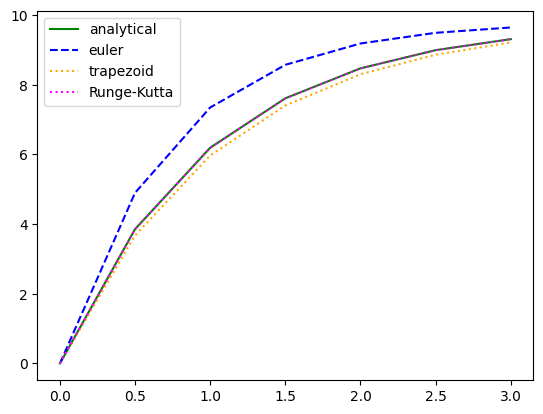

In [11]:
plot_data(ft_df).show()

### area (2nd integral)

In [12]:
area_df = pd.read_csv(
    HERE / "result" / "area.csv",
)
area_df

,timestamp,euler,trapezoid,rk4,analytical
0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.5,1.225000,0.918750,0.963411,0.000000
2,1.0,4.287500,3.330469,3.474805,1.044001
3,1.5,8.268750,6.675293,6.925467,3.605219
4,2.0,12.709375,10.603308,10.946053,7.086676
5,2.5,17.379688,14.895817,15.312449,11.126286
6,3.0,22.164845,19.416136,19.888674,15.504433


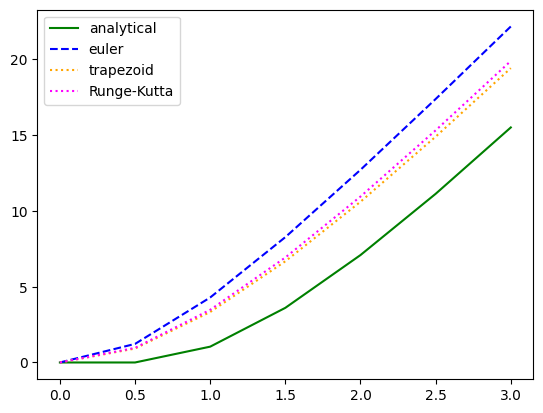

In [13]:
plot_data(area_df).show()

## Changing timestep

In [14]:
def plot_err(df) -> plt:
    plt.plot(
        df["timestep"], df["euler"],
        label="euler",
        color="blue",
        linestyle="--"
    )
    plt.plot(
        df["timestep"], df["trapezoid"],
        label="trapezoid",
        color="orange",
        linestyle=":"
    )
    plt.plot(
        df["timestep"], df["rk4"],
        label="Runge-Kutta",
        color="magenta",
        linestyle=":"
    )
    plt.xscale("log")
    plt.legend()
    return plt

In [15]:
ft_error = {
    "timestep": [],
    "euler": [],
    "trapezoid": [],
    "rk4": [],
}
area_error = copy.deepcopy(ft_error)

for i in range(1, 6):
    timestep = 0.1 ** i
    new_config = {
        'time_end'    : 3,
        'time_step'   : timestep,
        'f_0'         : 0,
        'ft_fname'    : 'f_t.csv',
        'area_fname'  : 'area.csv',
        'model_params': {
            "mass"     : 10,
            "viscosity": 10,
        }
    }
    with open(HERE / 'config' / 'settings.yaml', 'w') as f:
        yaml.dump(new_config, f)

    !cargo run

    ft_df = pd.read_csv(HERE / "result" / "f_t.csv")
    ft_rmse = rmse(ft_df)
    area_df = pd.read_csv(HERE / "result" / "area.csv")

    for method in ft_error:
        if method == "timestep":
            ft_error["timestep"].append(timestep)
            area_error["timestep"].append(timestep)
            continue
        ft_error[method].append(
            ft_rmse[method]
        )
        area_error[method].append(
            area_df.iloc[-1, -1]
            - area_df.iloc[-1, :][method]
        )

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.02s
     Running `target/debug/solver`
Solver { time_end: 3.0, time_step: 0.1, f_0: 0.0, mass: 10.0, viscosity: 10.0, gravity: 9.8 }

=== Final Values f(3) ===
Analytical solution: 9.312087
Euler method:        9.426110
Trapezoidal method:  9.356053
Runge-Kutta method:  9.358518

=== Integrals ∫f(t)dt from 0 to 3 ===
Analytical integral:           20.087908
Euler ODE + Trap integration:  21.425200
Trap ODE + Trap integration:   20.999329
RK4 ODE + Trap integration:    21.013680

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.01s
     Running `target/debug/solver`
Solver { time_end: 3.0, time_step: 0.01, f_0: 0.0, mass: 10.0, viscosity: 10.0, gravity: 9.8 }

=== Final Values f(3) ===
Analytical solution: 9.312087
Euler method:        9.324203
Trapezoidal method:  9.316922
Runge-Kutta method:  9.316941

=== Integrals ∫f(t)dt from 0 to 3 ===
Analytical integral:           20.087891
Euler ODE + Trap in

In [16]:
ft_err_df = pd.DataFrame(ft_error)
ft_err_df

,timestep,euler,trapezoid,rk4
0,0.10000,1.904973e-02,2.307118e-05,6.320262e-12
1,0.01000,1.879597e-04,1.985190e-09,2.735641e-12
2,0.00100,1.874642e-06,6.889929e-10,6.900937e-10
3,0.00010,4.978814e-08,5.150001e-08,5.150003e-08
4,0.00001,8.386753e-06,8.468479e-06,8.467655e-06


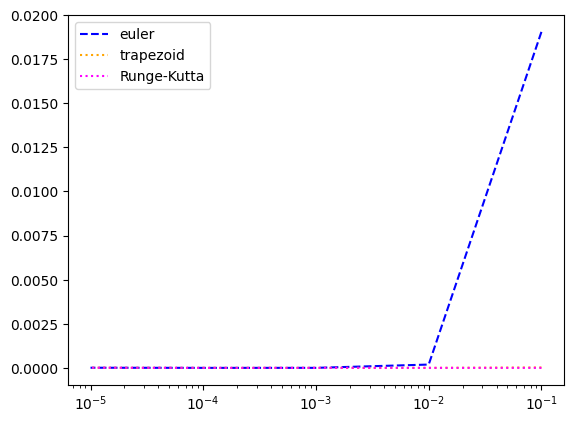

In [17]:
plot_err(ft_err_df).show()

In [18]:
area_err_df = pd.DataFrame(area_error)
area_err_df

,timestep,euler,trapezoid,rk4
0,0.10000,-1.337292,-0.911421,-0.925772
1,0.01000,-0.132521,-0.092961,-0.093074
2,0.00100,-0.013588,-0.009650,-0.009652
3,0.00010,-0.008839,-0.008434,-0.008434
4,0.00001,0.030857,0.030904,0.030904


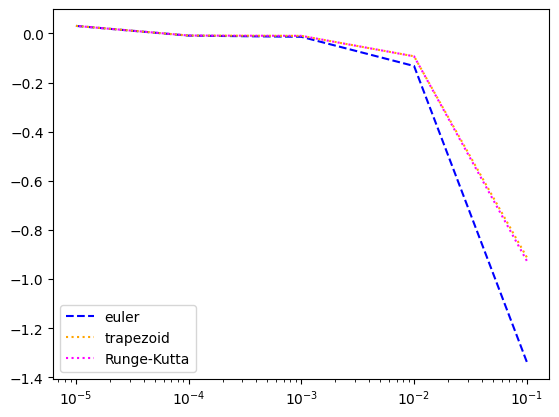

In [19]:
plot_err(area_err_df).show()